In [100]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sklearn.svm as svm
import numpy as np

import cv2
import glob
import time
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.externals import joblib

from collections import deque
from scipy.ndimage.measurements import label

from udacity_lesson_functions import *
from udacity_search_classify import *

import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

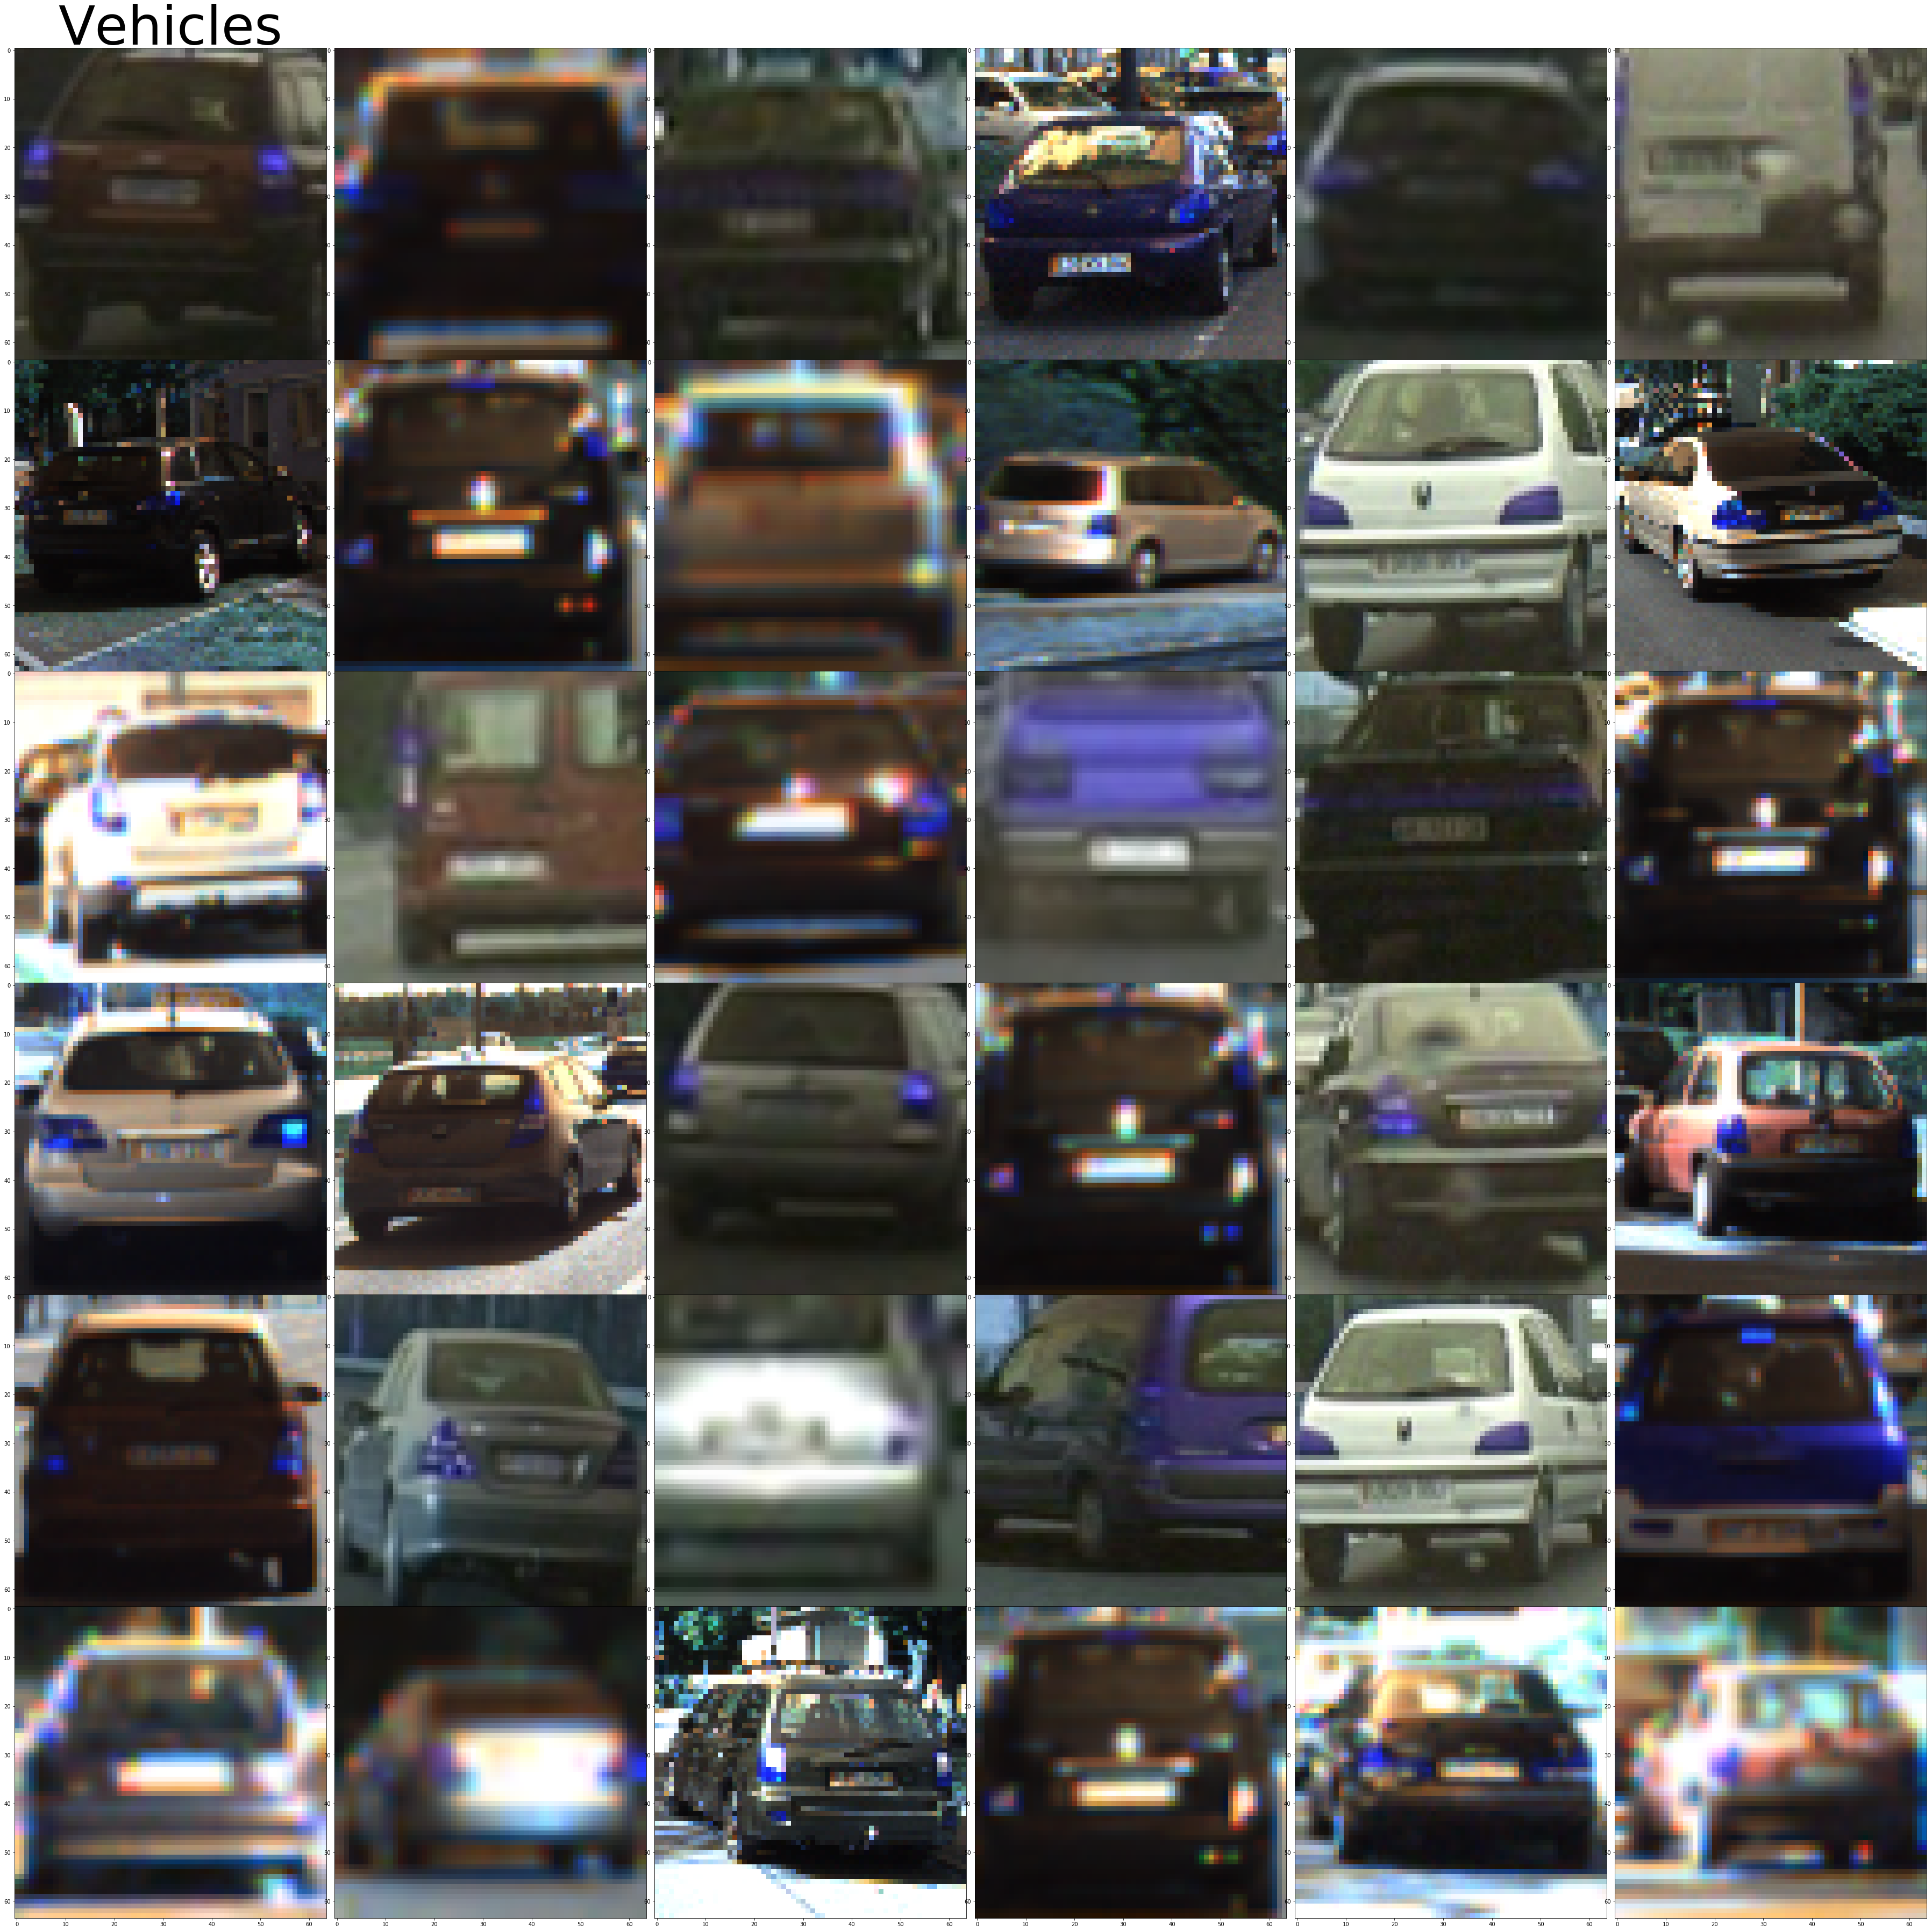

In [3]:
vehicle_n_nonvehicle = glob.glob('train/*/*/*.png')
vehicles = []
non_vehicles = []
all_vehicles =[]
all_non_vehicles = []

for v_and_nv in vehicle_n_nonvehicle:
    if 'non-vehicle' in v_and_nv:
        all_non_vehicles.append(v_and_nv)
    else:
        all_vehicles.append(v_and_nv)
        
for i, non_vehicle in enumerate(all_non_vehicles):
    non_vehicles.append(non_vehicle)
        
for j, vehicle in enumerate(all_vehicles):
    vehicles.append(vehicle)
        
vehicle_len = len(vehicles)
non_vehicle_len = len(non_vehicles)

ran_idx = []
vehicle_img = []
non_vehicle_img = []

for k in range(36):
    ran_idx.append(np.random.randint(0, vehicle_len))
    vehicle_img.append(vehicles[ran_idx[k]])

fig = plt.figure(figsize=(64, 64))
w_ratio = [1 for n in range(6)]
h_ratio = [1 for n in range(6)]
grid = gridspec.GridSpec(6, 6, wspace=0.0, hspace=0.0, width_ratios=w_ratio, height_ratios=h_ratio)

for idx, img in enumerate(vehicle_img):
    vimg = cv2.imread(img)
    ax = plt.Subplot(fig, grid[idx])
    ax.imshow(vimg)
    if idx == 0:
        ax.set_title('Vehicles', fontsize = 100)
    fig.add_subplot(ax)

plt.show()

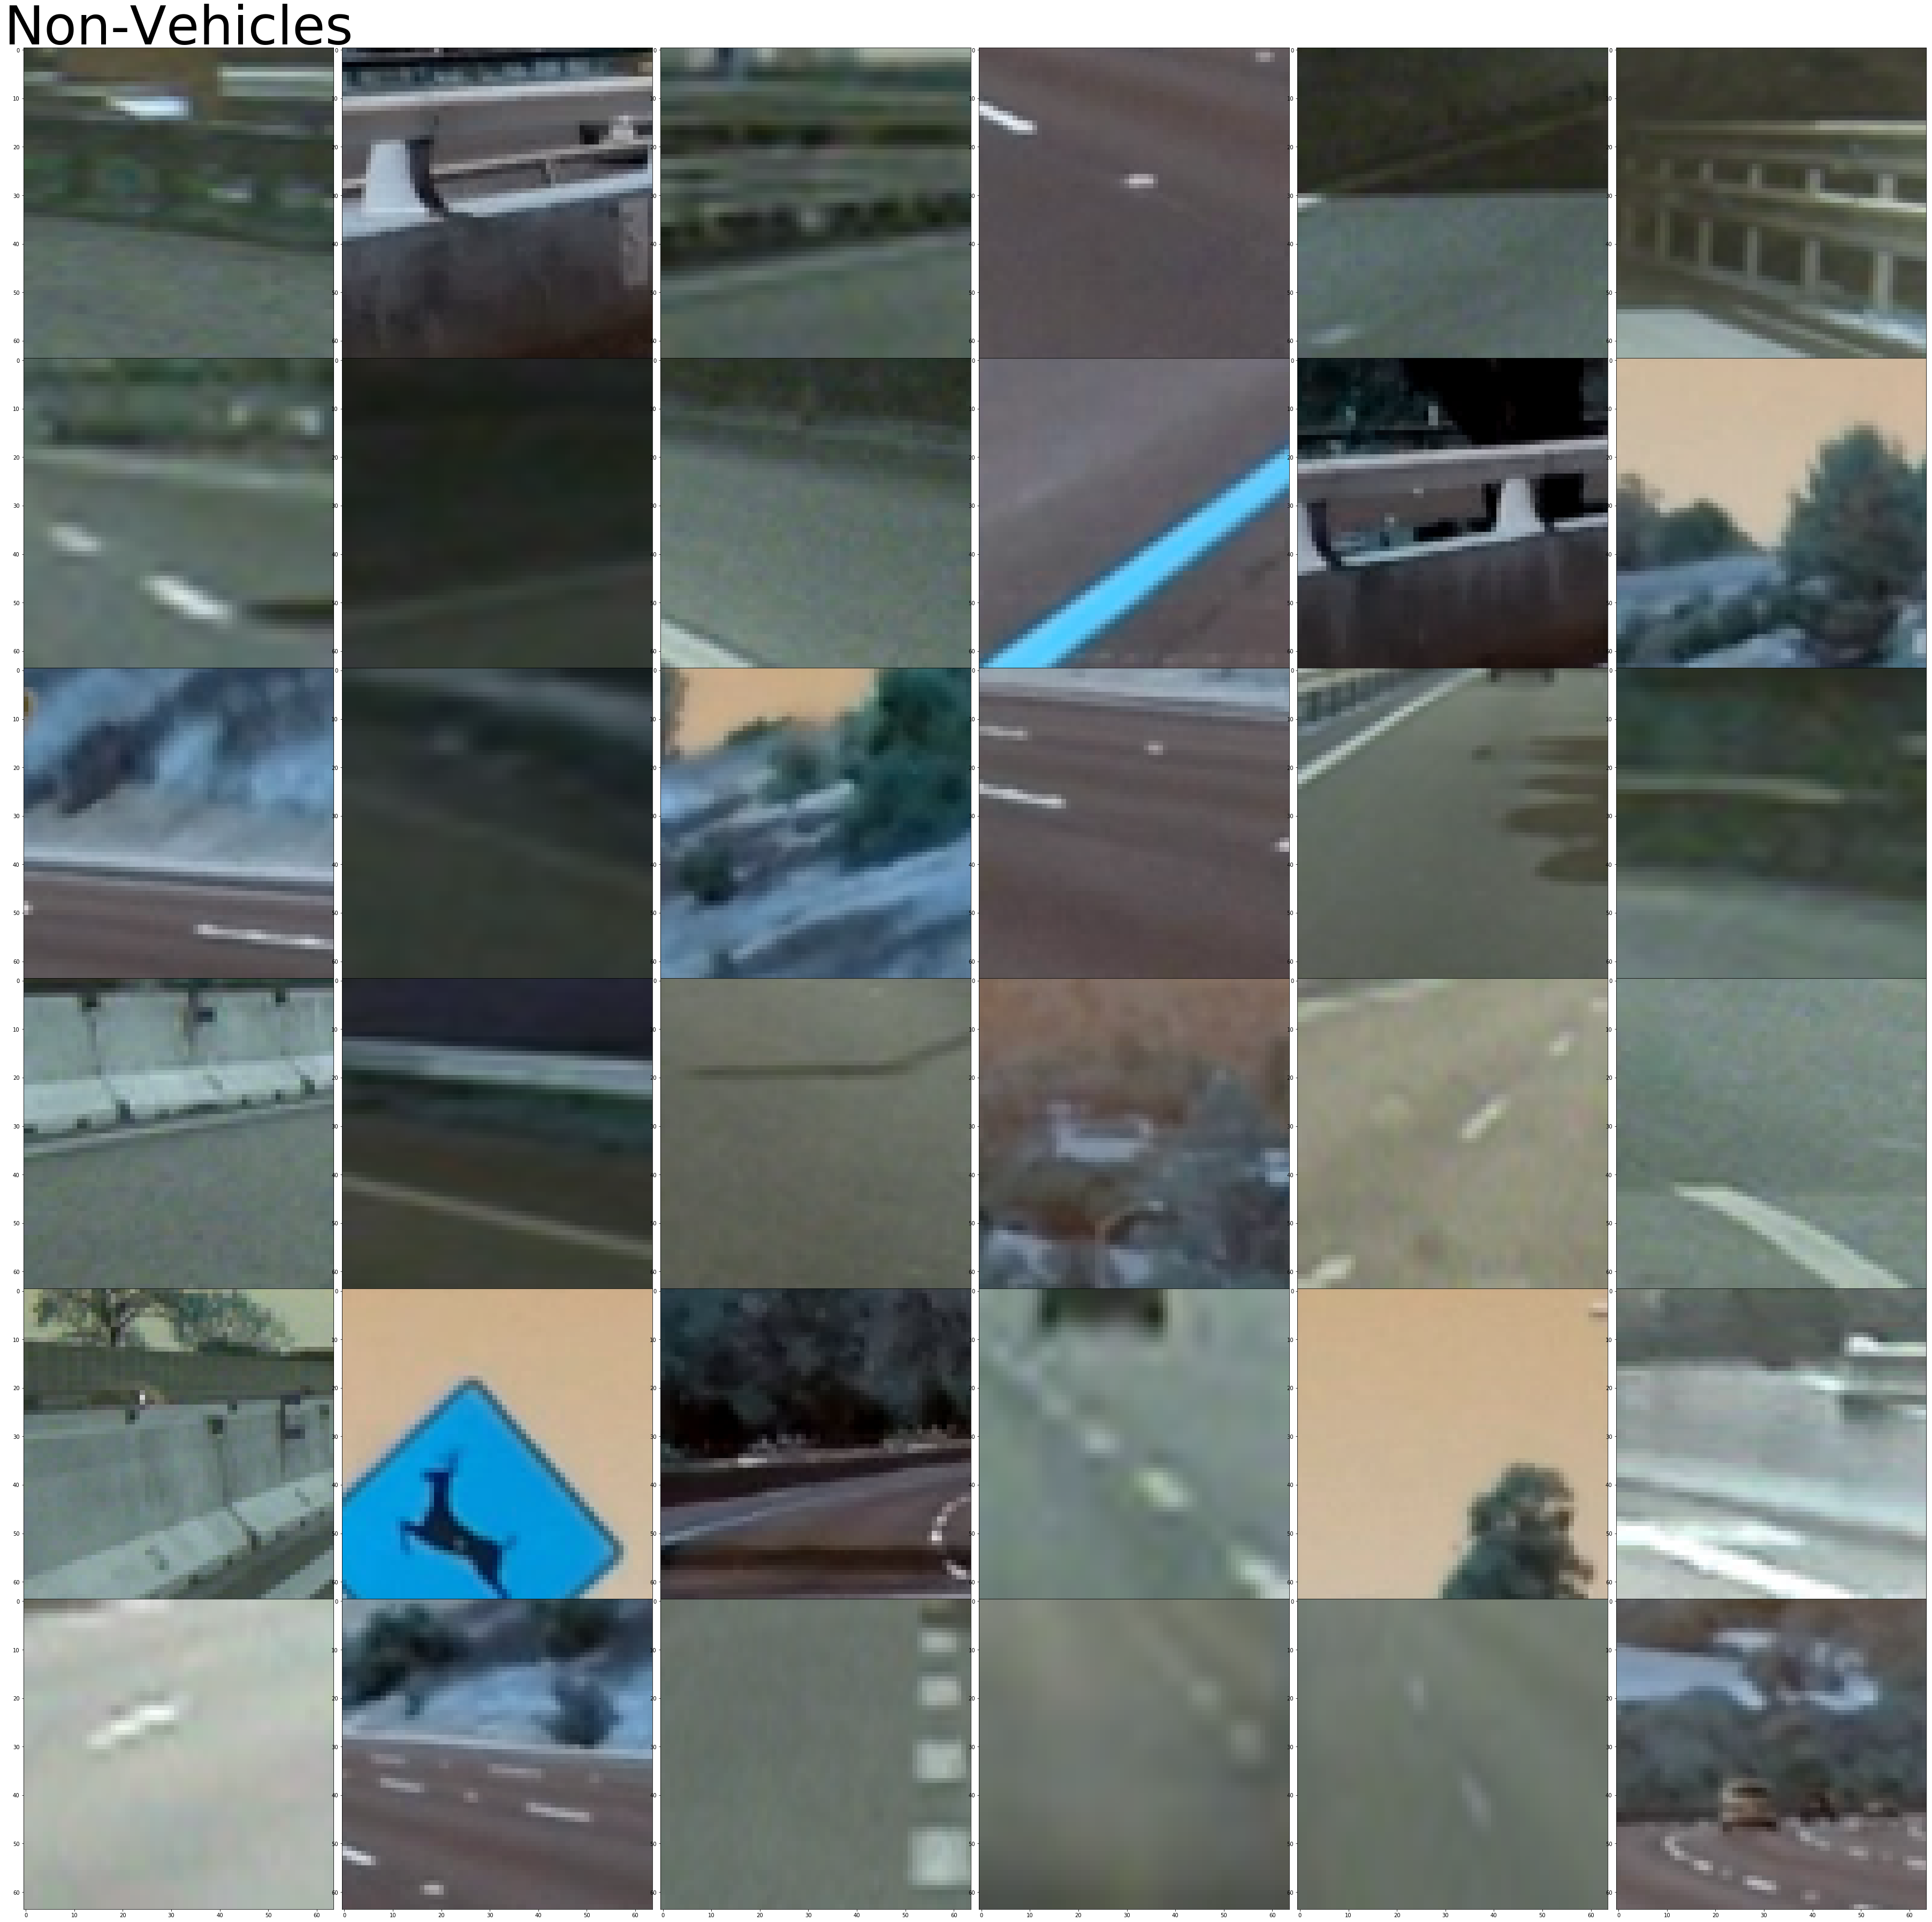

In [4]:
vehicle_n_nonvehicle = glob.glob('train/*/*/*.png')
non_vehicles = []
all_non_vehicles = []

for v_and_nv in vehicle_n_nonvehicle:
    if 'non-vehicle' in v_and_nv:
        all_non_vehicles.append(v_and_nv)
        
for i, non_vehicle in enumerate(all_non_vehicles):
    non_vehicles.append(non_vehicle)
        
non_vehicle_len = len(non_vehicles)

ran_idx = []
non_vehicle_img = []

for k in range(36):
    ran_idx.append(np.random.randint(0, non_vehicle_len))
    non_vehicle_img.append(non_vehicles[ran_idx[k]])

fig = plt.figure(figsize=(64, 64))
w_ratio = [1 for n in range(6)]
h_ratio = [1 for n in range(6)]
grid = gridspec.GridSpec(6, 6, wspace=0.0, hspace=0.0, width_ratios=w_ratio, height_ratios=h_ratio)

for idx, img in enumerate(non_vehicle_img):
    nvimg = cv2.imread(img)
    ax = plt.Subplot(fig, grid[idx])
    ax.imshow(nvimg)
    if idx == 0:
        ax.set_title('Non-Vehicles', fontsize = 100)
    fig.add_subplot(ax)

plt.show()

In [95]:
vehicle_n_nonvehicle = glob.glob('train/*/*/*.png')
vehicles = []
non_vehicles = []
all_vehicles =[]
all_non_vehicles = []

for v_and_nv in vehicle_n_nonvehicle:
    if 'non-vehicle' in v_and_nv:
        all_non_vehicles.append(v_and_nv)
    else:
        all_vehicles.append(v_and_nv)
        
for i, non_vehicle in enumerate(all_non_vehicles):
    non_vehicles.append(non_vehicle)
        
for j, vehicle in enumerate(all_vehicles):
    vehicles.append(vehicle)
        
vehicle_len = len(vehicles)
non_vehicle_len = len(non_vehicles)

train = 0.7
valid = 0.2
tests = 0.1

test1 = round(vehicle_len * train)
test2 = round(non_vehicle_len * train)

print('test1, test2 : ', test1, test2)

mini = (train * np.array([vehicle_len, non_vehicle_len])).astype('int')
maxi = ((train + valid) * np.array([vehicle_len, non_vehicle_len])).astype('int')

print(mini)
print(maxi)

vehicle_train = vehicles[:mini[0]]
vehicle_valid = vehicles[mini[0]:maxi[0]]
vehicle_tests = vehicles[maxi[0]:]

non_vehicle_train = non_vehicles[:mini[1]]
non_vehicle_valid = non_vehicles[mini[1]:maxi[1]]
non_vehicle_tests = non_vehicles[maxi[1]:]

print('Number of samples in Vehicle Training: ', len(vehicle_train))
print('Number of samples in Vehicle Validation: ', len(vehicle_valid))
print('Number of samples in Vehicle Test: ', len(vehicle_tests))

print('Number of samples in Non-Vehicle Training: ', len(non_vehicle_train))
print('Number of samples in Non-Vehicle Validation: ', len(non_vehicle_valid))
print('Number of samples in Non-Vehicle Test: ', len(non_vehicle_tests))

test1, test2 :  6154 6278
[6154 6277]
[7912 8071]
Number of samples in Vehicle Training:  6154
Number of samples in Vehicle Validation:  1758
Number of samples in Vehicle Test:  880
Number of samples in Non-Vehicle Training:  6277
Number of samples in Non-Vehicle Validation:  1794
Number of samples in Non-Vehicle Test:  897


In [8]:
vehicle_true_false_file = 'vehicle_true_false_data.p'
print('Saving Vehicle true false data to pickle file')
try:
    with open(vehicle_true_false_file, 'wb') as pfile:
        pickle.dump(
            {
                'vehicle_train': vehicle_train,
                'vehicle_valid': vehicle_valid,
                'vehicle_tests': vehicle_tests,
                'non_vehicle_train': non_vehicle_train,
                'non_vehicle_valid': non_vehicle_valid,
                'non_vehicle_tests': non_vehicle_tests
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save Vehicle true false data to', pickle_file, ':', e)
    raise

print('Vehicle true false data saved in pickle file.')

Saving Vehicle true false data to pickle file
Vehicle true false data saved in pickle file.


Check Vehicle True False Data:
train/vehicles/KITTI_extracted/1564.png
train/non-vehicles/GTI/image2840.png


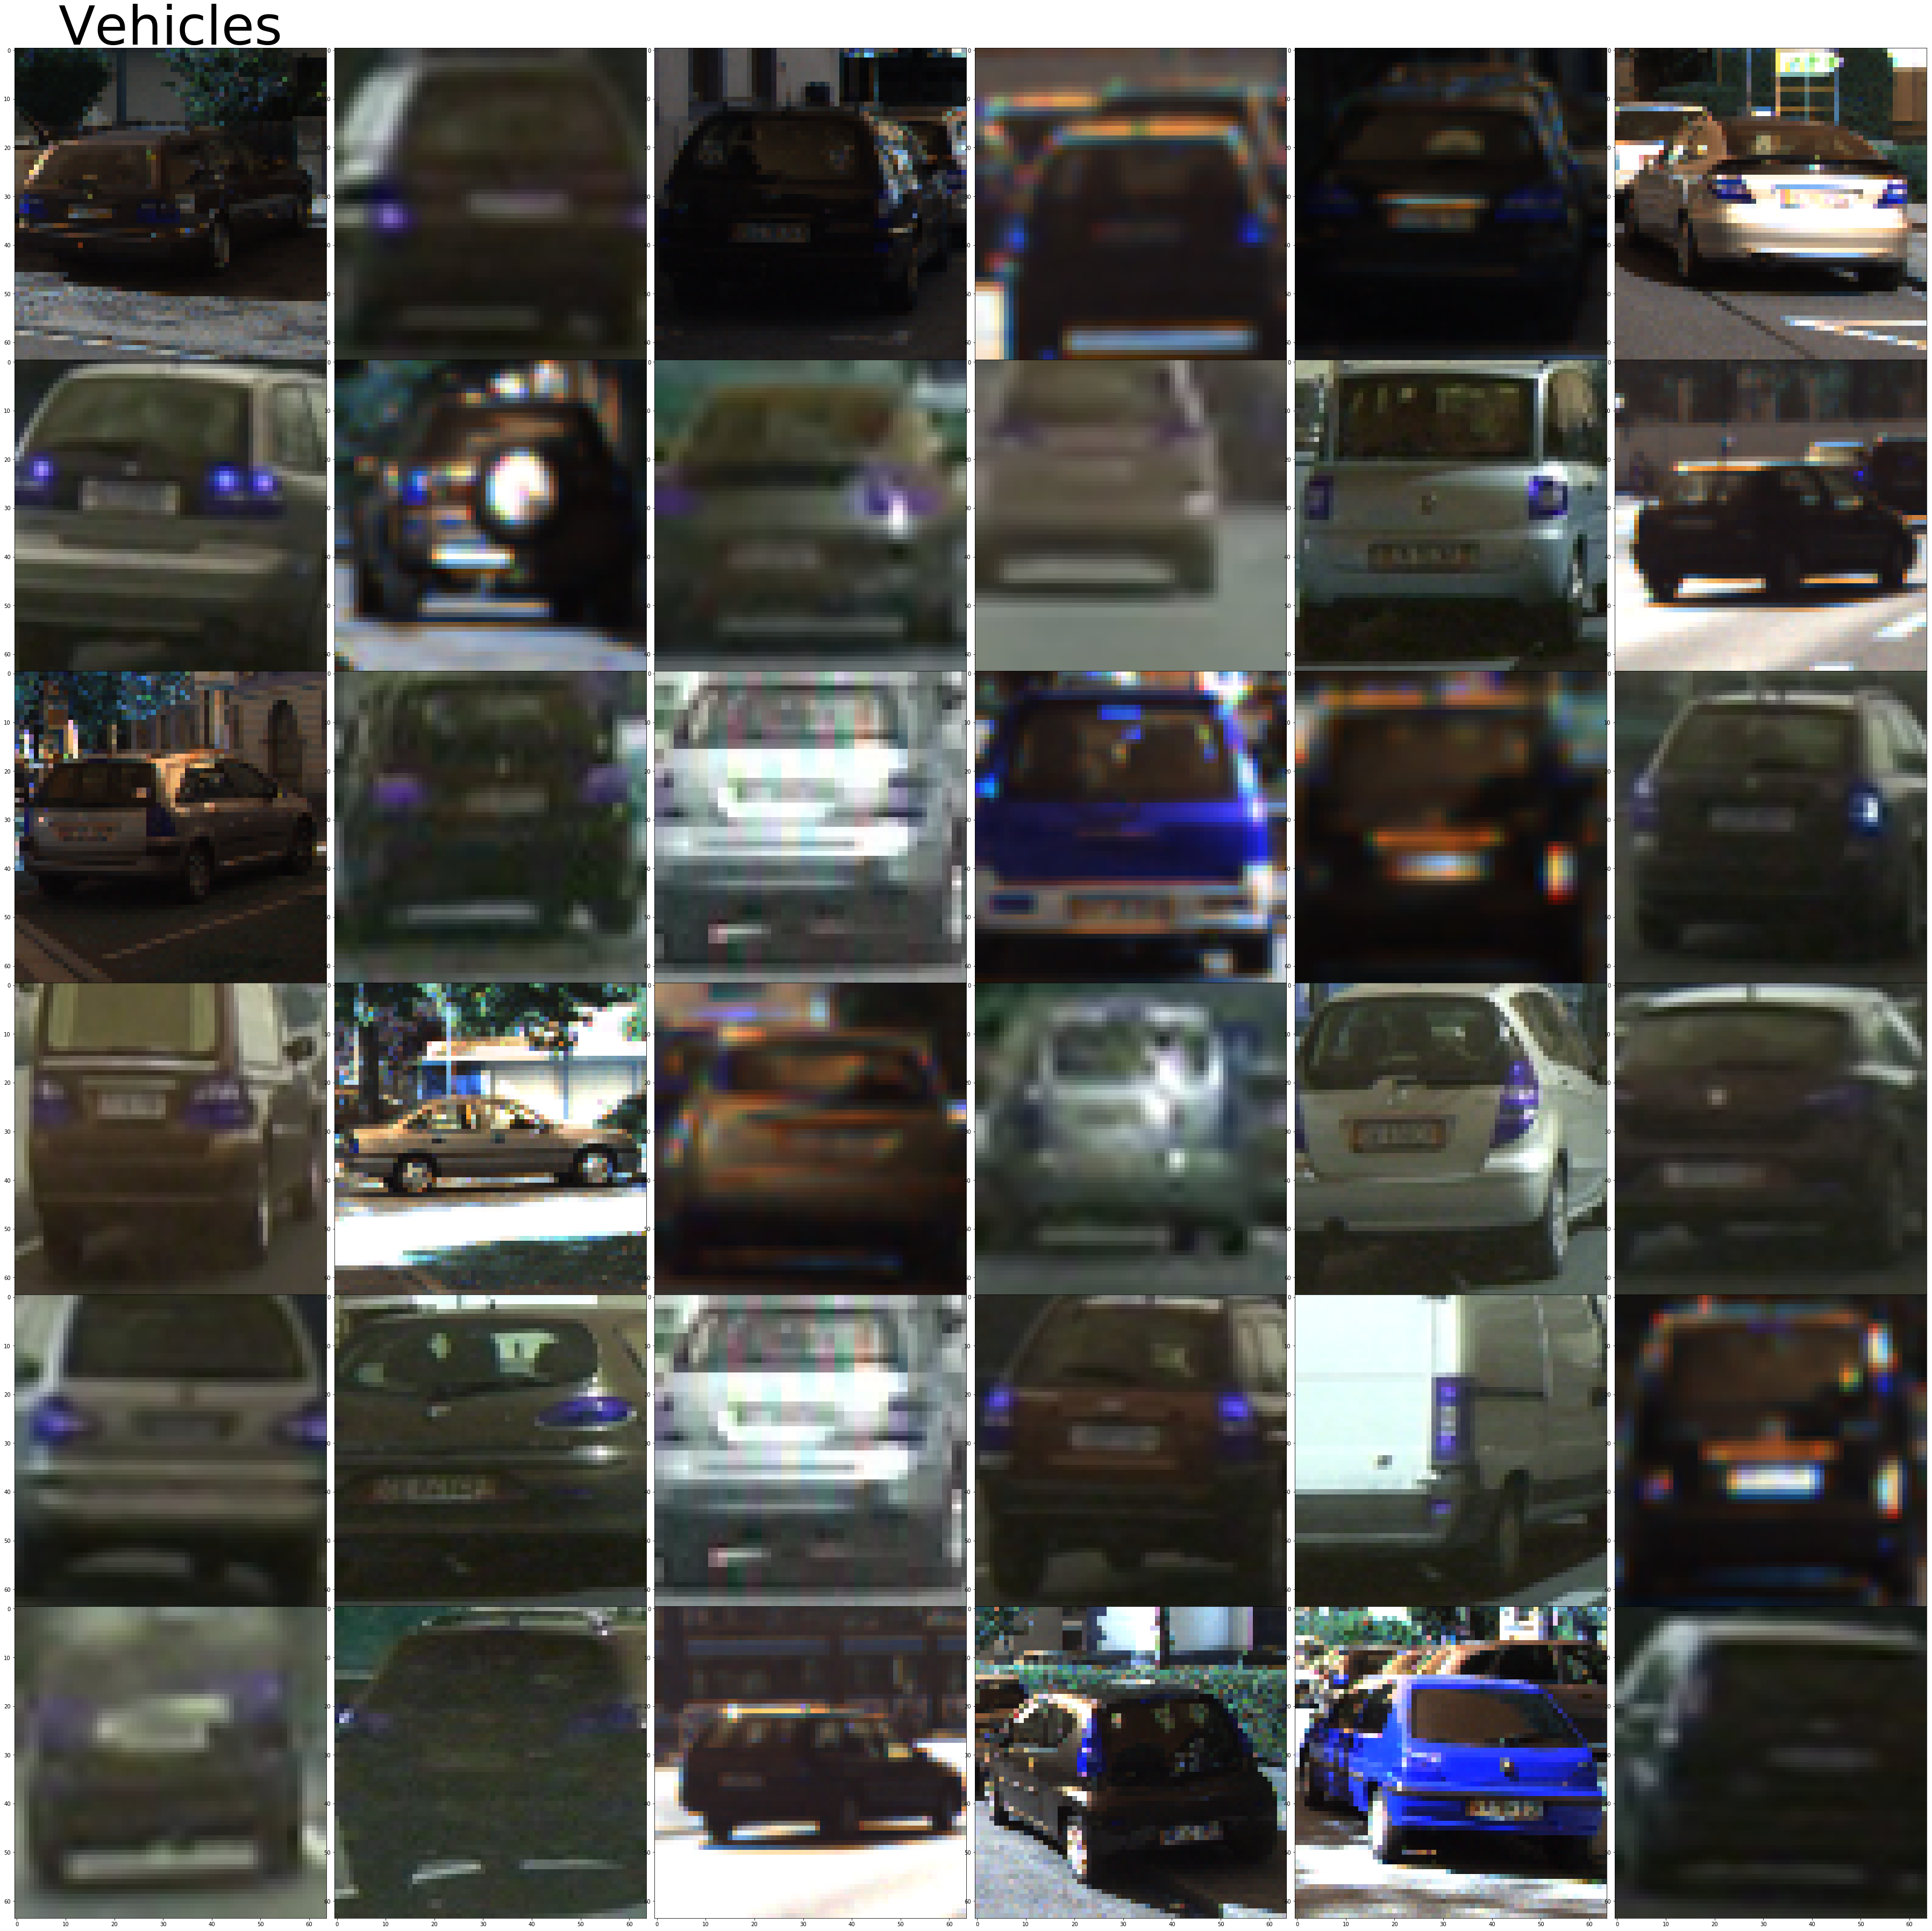

In [9]:
vehicle_true_false_file = 'vehicle_true_false_data.p'
with open(vehicle_true_false_file, mode='rb') as f:
    data = pickle.load(f)
vehicle_train = data['vehicle_train']
vehicle_valid = data['vehicle_valid']
vehicle_tests = data['vehicle_tests']
non_vehicle_train = data['non_vehicle_train']
non_vehicle_valid = data['non_vehicle_valid']
non_vehicle_tests = data['non_vehicle_tests']

ran_idx = []
vehicle_img = []
non_vehicle_img = []

for k in range(36):
    ran_idx.append(np.random.randint(0, 3333))
    vehicle_img.append(vehicle_train[ran_idx[k]])
    non_vehicle_img.append(non_vehicle_train[ran_idx[k]])
    
fig = plt.figure(figsize=(64, 64))
w_ratio = [1 for n in range(6)]
h_ratio = [1 for n in range(6)]
grid = gridspec.GridSpec(6, 6, wspace=0.0, hspace=0.0, width_ratios=w_ratio, height_ratios=h_ratio)

for idx, img in enumerate(vehicle_img):
    vimg = cv2.imread(img)
    ax = plt.Subplot(fig, grid[idx])
    ax.imshow(vimg)
    if idx == 0:
        ax.set_title('Vehicles', fontsize = 100)
    fig.add_subplot(ax)

#vehicle = plt.imread(vehicle_train[pick_one])
#non_vehicle = plt.imread(non_vehicle_train[pick_one])
pick_one = np.random.randint(0, 3333)
print('Check Vehicle True False Data:')
print(vehicle_train[pick_one])
print(non_vehicle_train[pick_one])

#plt.imshow(vehicle)
plt.show()

Check Vehicle True False Data:
train/vehicles/GTI_Far/image0721.png
train/non-vehicles/GTI/image2986.png


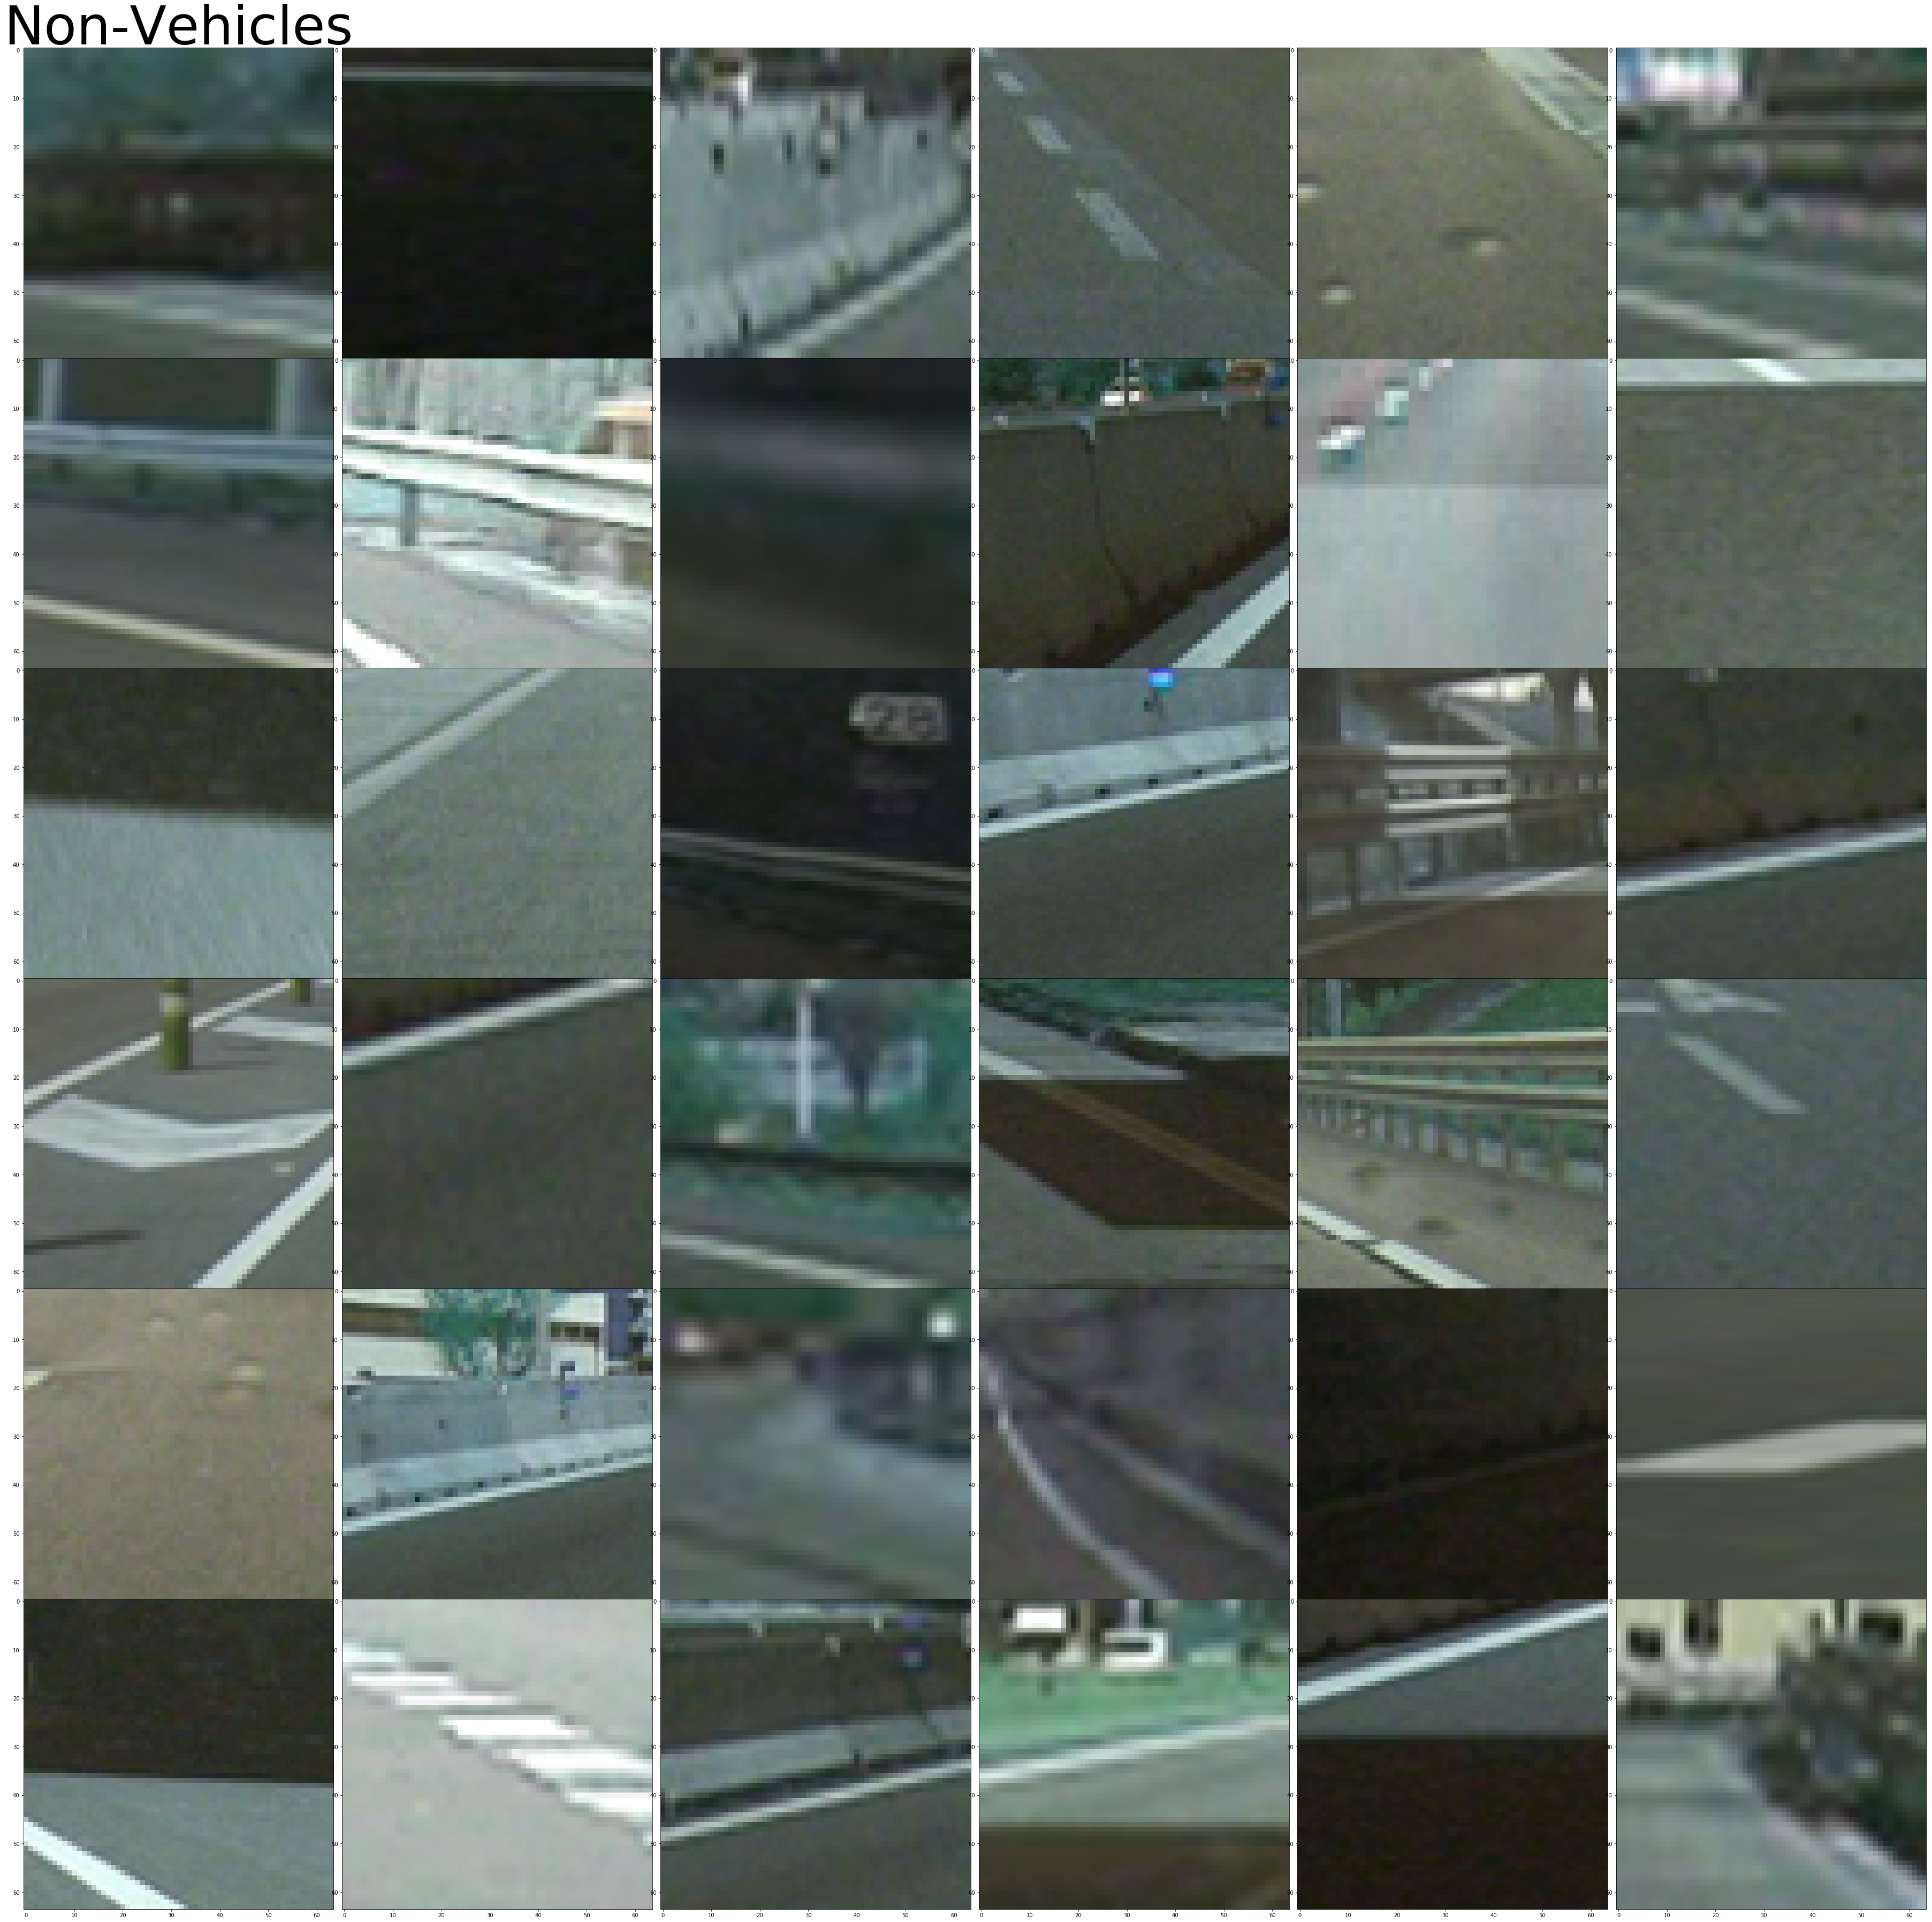

In [10]:
vehicle_true_false_file = 'vehicle_true_false_data.p'
with open(vehicle_true_false_file, mode='rb') as f:
    data = pickle.load(f)
vehicle_train = data['vehicle_train']
vehicle_valid = data['vehicle_valid']
vehicle_tests = data['vehicle_tests']
non_vehicle_train = data['non_vehicle_train']
non_vehicle_valid = data['non_vehicle_valid']
non_vehicle_tests = data['non_vehicle_tests']

ran_idx = []
vehicle_img = []
non_vehicle_img = []

for k in range(36):
    ran_idx.append(np.random.randint(0, 3333))
    vehicle_img.append(vehicle_train[ran_idx[k]])
    non_vehicle_img.append(non_vehicle_train[ran_idx[k]])
    
fig = plt.figure(figsize=(64, 64))
w_ratio = [1 for n in range(6)]
h_ratio = [1 for n in range(6)]
grid = gridspec.GridSpec(6, 6, wspace=0.0, hspace=0.0, width_ratios=w_ratio, height_ratios=h_ratio)

for idx, img in enumerate(non_vehicle_img):
    nvimg = cv2.imread(img)
    ax = plt.Subplot(fig, grid[idx])
    ax.imshow(nvimg)
    if idx == 0:
        ax.set_title('Non-Vehicles', fontsize = 100)
    fig.add_subplot(ax)

#vehicle = plt.imread(vehicle_train[pick_one])
#non_vehicle = plt.imread(non_vehicle_train[pick_one])
pick_one = np.random.randint(0, 3333)
print('Check Vehicle True False Data:')
print(vehicle_train[pick_one])
print(non_vehicle_train[pick_one])

#plt.imshow(vehicle)
plt.show()

In [11]:
vehicle_true_false_file = 'vehicle_true_false_data.p'
with open(vehicle_true_false_file, mode='rb') as f:
    data = pickle.load(f)
vehicle_train = data['vehicle_train']
vehicle_valid = data['vehicle_valid']
vehicle_tests = data['vehicle_tests']
non_vehicle_train = data['non_vehicle_train']
non_vehicle_valid = data['non_vehicle_valid']
non_vehicle_tests = data['non_vehicle_tests']

def collect_features(files, color_space='RGB', spatial_size=(32, 32),
                 hist_bins=32, orient=9, pix_per_cell=8, 
                 cell_per_block=2, hog_channel=0,
                 spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:  
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space=color_space, 
                                           spatial_size=spatial_size, 
                                           hist_bins=hist_bins, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, 
                                           hog_channel=hog_channel, 
                                           spatial_feat=spatial_feat, 
                                           hist_feat=hist_feat, 
                                           hog_feat=hog_feat)
        
        features.append(img_features)
        
    return features

In [13]:
### This code is based on Udacity Lecture 34(Search and Classify)
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
vehicle_train_feat = collect_features(vehicle_train, color_space, spatial_size, 
                                      hist_bins, orient, pix_per_cell, cell_per_block,
                                      hog_channel, spatial_feat, hist_feat, hog_feat)
vehicle_valid_feat = collect_features(vehicle_valid, color_space, spatial_size, 
                                      hist_bins, orient, pix_per_cell, cell_per_block,
                                      hog_channel, spatial_feat, hist_feat, hog_feat)
vehicle_tests_feat = collect_features(vehicle_tests, color_space, spatial_size, 
                                      hist_bins, orient, pix_per_cell, cell_per_block,
                                      hog_channel, spatial_feat, hist_feat, hog_feat)

non_vehicle_train_feat = collect_features(non_vehicle_train, color_space, spatial_size,
                                          hist_bins, orient, pix_per_cell, cell_per_block,
                                          hog_channel, spatial_feat, hist_feat, hog_feat)
non_vehicle_valid_feat = collect_features(non_vehicle_valid, color_space, spatial_size,
                                          hist_bins, orient, pix_per_cell, cell_per_block, 
                                          hog_channel, spatial_feat, hist_feat, hog_feat)
non_vehicle_tests_feat = collect_features(non_vehicle_tests, color_space, spatial_size,
                                          hist_bins, orient, pix_per_cell, cell_per_block,
                                          hog_channel, spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG,spatial and color features...')

/home/sdr/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


80.08 Seconds to extract HOG,spatial and color features...


In [31]:
### This code is based on Udacity Lecture 34(Search and Classify)
X = np.vstack((vehicle_train_feat, vehicle_valid_feat, vehicle_tests_feat,
               non_vehicle_train_feat, non_vehicle_valid_feat, non_vehicle_tests_feat)
             ).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

vehicle_ntrain = len(vehicle_train_feat)
vehicle_nvalid = len(vehicle_valid_feat)
vehicle_ntests = len(vehicle_tests_feat)
non_vehicle_ntrain = len(non_vehicle_train_feat)
non_vehicle_nvalid = len(non_vehicle_valid_feat)
non_vehicle_ntests = len(non_vehicle_tests_feat)

values = [vehicle_ntrain, vehicle_nvalid, vehicle_ntests, non_vehicle_ntrain, non_vehicle_nvalid]
bounds = np.array(range(5))

for idx in range(len(values)):
    #print('idx : ', idx)
    rval = 0
    for i in range(idx + 1):
        rval += values[i]
        #print('rval : ', rval)
    bounds[i] = rval

vehicle_train_feat, vehicle_valid_feat, vehicle_tests_feat = scaled_X[:bounds[0]],scaled_X[bounds[0]:bounds[1]],scaled_X[bounds[1]:bounds[2]]
non_vehicle_train_feat, non_vehicle_valid_feat, non_vehicle_tests_feat = scaled_X[bounds[2]:bounds[3]],scaled_X[bounds[3]:bounds[4]],scaled_X[bounds[4]:]

y_train = np.hstack((np.ones(vehicle_ntrain), np.zeros(non_vehicle_ntrain)))
y_valid = np.hstack((np.ones(vehicle_nvalid), np.zeros(non_vehicle_nvalid)))
y_tests = np.hstack((np.ones(vehicle_ntests), np.zeros(non_vehicle_ntests)))

X_train = np.vstack((scaled_X[:bounds[0]],scaled_X[bounds[2]:bounds[3]]))
X_valid = np.vstack((scaled_X[bounds[0]:bounds[1]],scaled_X[bounds[3]:bounds[4]]))
X_tests = np.vstack((scaled_X[bounds[1]:bounds[2]],scaled_X[bounds[4]:]))

X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_valid,y_valid = shuffle(X_valid,y_valid,random_state=42)
X_tests,y_tests = shuffle(X_tests,y_tests,random_state=42)

In [35]:
### This code is based on Udacity Lecture 29(Hog Classify)
print('Using: ', orient, ' orientations ', pix_per_cell, 
      ' pixels per cell and ', cell_per_block, ' cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Validation Accuracy of SVC = ', round(svc.score(X_valid, y_valid), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_tests, y_tests), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 777
print('777 SVC predicts: ', svc.predict(X_valid[0:n_predict]))
print('For these',n_predict, 'labels: ', y_valid[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using:  9  orientations  8  pixels per cell and  2  cells per block
Feature vector length: 6156
0.99 Seconds to train SVC...
Validation Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9994
777 SVC predicts:  [ 1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.
  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  0.  0.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.
  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  1.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0. 

[2577, 2122, 1734, 1214, 40, 3056, 692, 2480, 1226, 594, 297, 911, 314, 914, 233, 2122]


/home/sdr/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


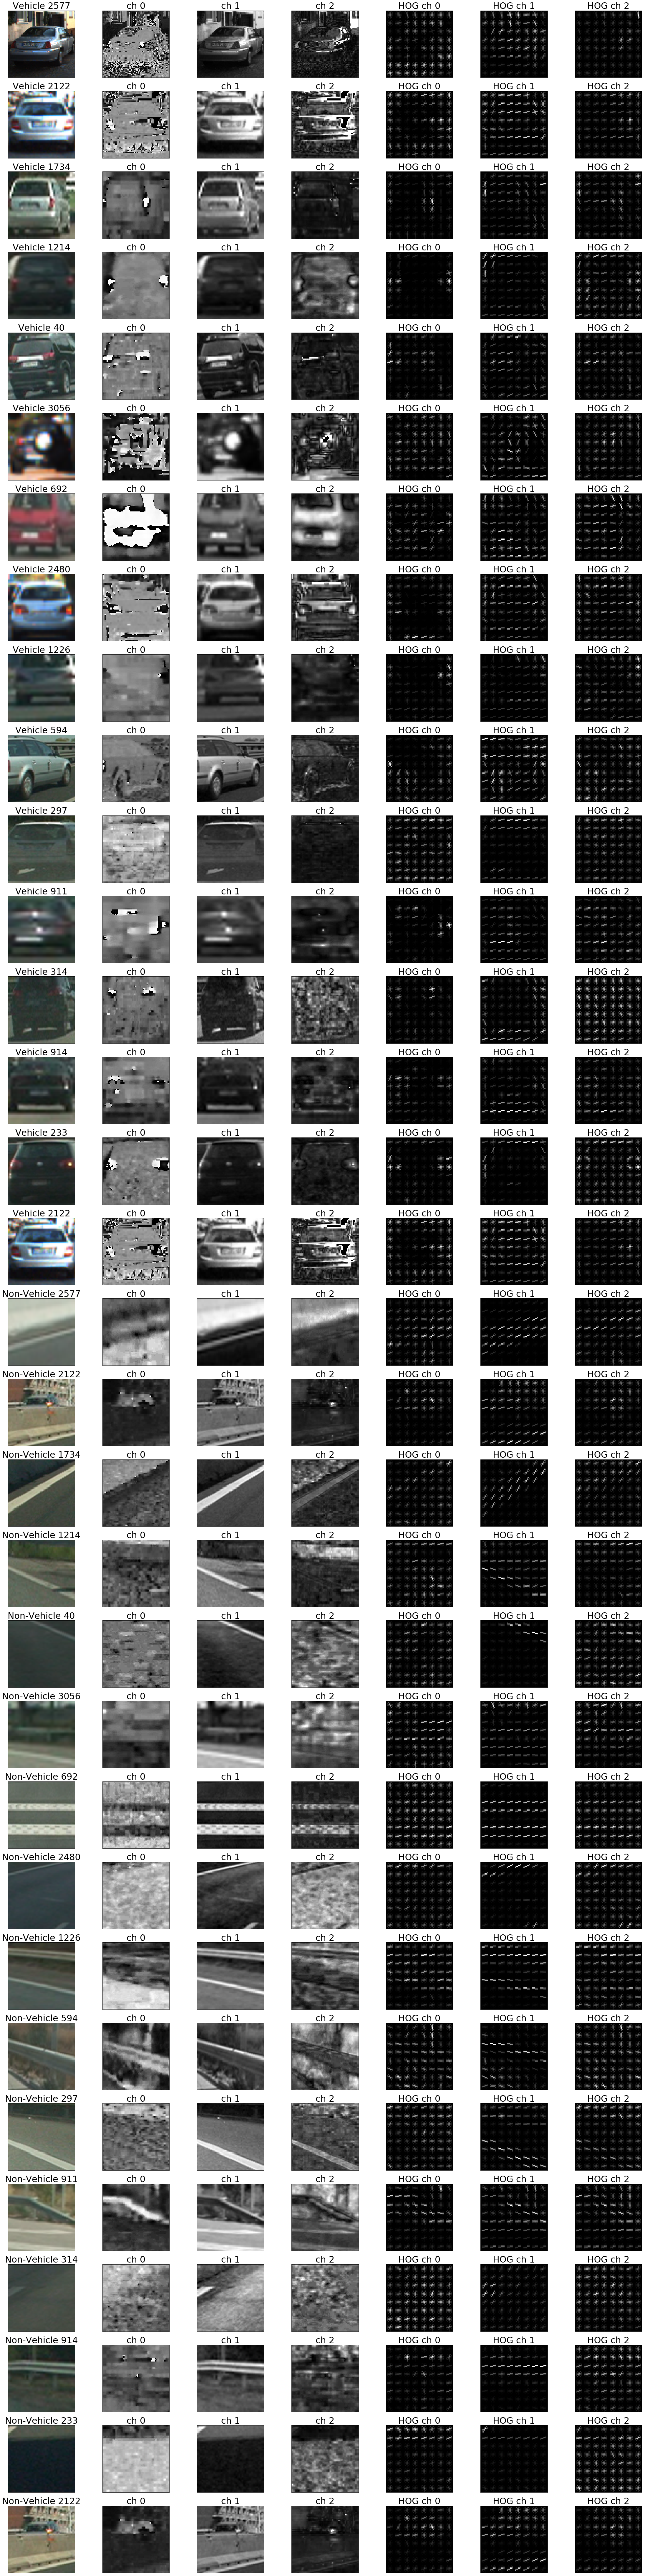

In [79]:
font_size = 30
num_of_fig = 32
column = 7
num_of_channel = 3
orig_fig_idx = 1

f, axarr = plt.subplots(num_of_fig, column,figsize=(40,160))
f.subplots_adjust(hspace=0.2, wspace=0.05)
colorspace = cv2.COLOR_RGB2HLS

pick = []

for i in range(int(num_of_fig / 2)):
    pick.append(np.random.randint(0, 3333))

print(pick)

for idx, j in enumerate(pick):
    img = plt.imread(vehicle_train[j])
    feat_img = cv2.cvtColor(img, colorspace)

    axarr[idx,0].imshow(img)
    axarr[idx,0].set_xticks([])
    axarr[idx,0].set_yticks([])
    title = "Vehicle {0}".format(j)
    axarr[idx,0].set_title(title, fontsize=font_size)

    for channel in range(num_of_channel):        
        axarr[idx, channel + orig_fig_idx].imshow(feat_img[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[idx, channel + orig_fig_idx].set_title(title, fontsize=font_size)
        axarr[idx, channel + orig_fig_idx].set_xticks([])
        axarr[idx, channel + orig_fig_idx].set_yticks([])    
    
    for channel in range(num_of_channel):
        features, hog_img = get_hog_features(feat_img[:,:,channel], orient, pix_per_cell, 
                                             cell_per_block, vis=True, feature_vec=True)
        axarr[idx, channel + orig_fig_idx + num_of_channel].imshow(hog_img, cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[idx, channel + orig_fig_idx + num_of_channel].set_title(title, fontsize=font_size)
        axarr[idx, channel + orig_fig_idx + num_of_channel].set_xticks([])
        axarr[idx, channel + orig_fig_idx + num_of_channel].set_yticks([])

for idx2,j in enumerate(pick):
    idx = idx2 + int(num_of_fig / 2)
    img = plt.imread(non_vehicle_train[j])
    feat_img = cv2.cvtColor(img, colorspace)

    axarr[idx,0].imshow(img)
    axarr[idx,0].set_xticks([])
    axarr[idx,0].set_yticks([])
    title = "Non-Vehicle {0}".format(j)
    axarr[idx,0].set_title(title, fontsize=font_size)

    for channel in range(num_of_channel):        
        axarr[idx,channel + orig_fig_idx].imshow(feat_img[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[idx, channel + orig_fig_idx].set_title(title, fontsize=font_size)
        axarr[idx, channel + orig_fig_idx].set_xticks([])
        axarr[idx, channel + orig_fig_idx].set_yticks([])        
    
    for channel in range(num_of_channel):
        features, hog_img = get_hog_features(feat_img[:,:,channel], orient, pix_per_cell, 
                                             cell_per_block, vis=True, feature_vec=True)
        axarr[idx, channel + orig_fig_idx + num_of_channel].imshow(hog_img, cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[idx, channel + orig_fig_idx + num_of_channel].set_title(title, fontsize=font_size)
        axarr[idx, channel + orig_fig_idx + num_of_channel].set_xticks([])
        axarr[idx, channel + orig_fig_idx + num_of_channel].set_yticks([])
        
plt.show()

In [152]:
pickle_file = 'train_info.p'
print('Saving data to train_info.p file')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train,
                'X_valid': X_valid,
                'X_tests': X_tests,
                'y_train': y_train,
                'y_valid': y_valid,
                'y_tests': y_tests                
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
print('Data saved in train_info.p file.')

pickle_file = 'classifier.p'
print('Saving data to classifier.p file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data saved in classifier.p file.')

Saving data to train_info.p file
Data saved in train_info.p file.
Saving data to classifier.p file...
Data saved in classifier.p file.


In [153]:
data_file = 'classifier.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

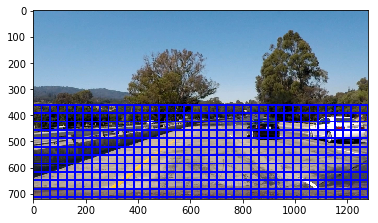

In [154]:
image = mpimg.imread('test_images/test1.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
def slide_window(img, x_start_stop, y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

windows = slide_window(image, x_start_stop=[0, 1280], 
                           y_start_stop=[360, 720],
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

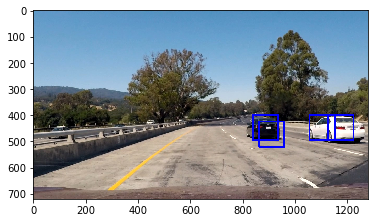

In [155]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
image = mpimg.imread('test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

In [156]:
boxes = BoundingBoxes(n=30)

def process_image(image):
    draw_image = np.copy(image)    
    out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return out_img

out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_project_video.mp4
[MoviePy] Writing video ./output_images/processed_project_video.mp4


  2%|▏         | 20/1261 [00:05<05:27,  3.79it/s]

KeyboardInterrupt: 